# Second-Level GLM Analysis and Multiple Comparisons

In the previous lesson we ran a first-level analysis on our data set. Each subject's activity was modeled using GLMs, and we saved those models to `first_level_models.p`. The next step is to combine these models to examine within-subject effects consistent across the group. 

In [17]:
import pickle
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nistats.reporting import get_clusters_table, make_glm_report
from nilearn.plotting import view_img

In [4]:
with open('first_level_models.p', 'rb') as f:
    glms = pickle.load(f)

## 1. Second Level Analysis

Second-level analysis is easily done with nistats' `SecondLevelModel` class [see online documentation](https://nistats.github.io/modules/generated/nistats.second_level_model.SecondLevelModel.html#nistats.second_level_model.SecondLevelModel). Like with `FirstLevelModel`, we define and then fit our second-level model. The first-level models we ran and saved last lesson will serve as inputs when fitting the second-level model.  



In [5]:
second_level = SecondLevelModel()
second_level.fit(glms)

SecondLevelModel(mask_img=None, memory=Memory(location=None), memory_level=1,
                 minimize_memory=True, n_jobs=1, smoothing_fwhm=None,
                 verbose=0)

Here, second-level analysis is much faster than first-level analysis. This is because this dataset is all within-subjects, so all the heavy-lifting was done in the first-level analysis. If we had two different groups that we wanted to compare, then second-level analysis would have a greater role.

Next, we can compute a group contrasts to examine our group effects. Because we're looking for voxels that are consistently activated across subjects, we want to see if each voxel is significantly greater (or less) than 0. This is done by running a one-sample t-test for each voxel where we test against 0. Each voxel has 8 observations (the number of subjects), so the degrees of freedom for each voxel equals 7. 

By default, nistats convert the results to _z_-values and output a _z_ map. We can change this back to _t_ values using the `output_type` parameter. Both _z_ or _t_ maps are common; either works. We'll stick with _z_ values for now.   

In [11]:
z_map = second_level.compute_contrast(first_level_contrast='Finger', 
                                      second_level_stat_type='t', 
                                      output_type='z_score')


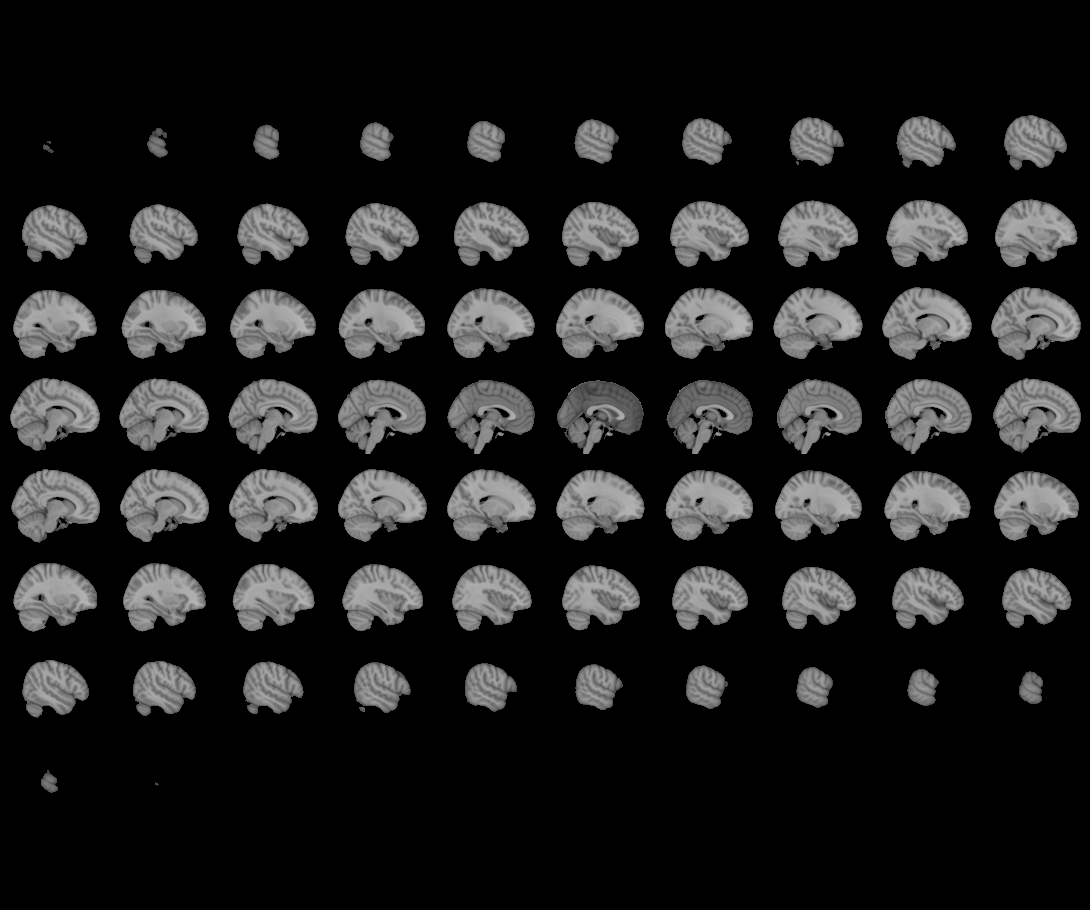
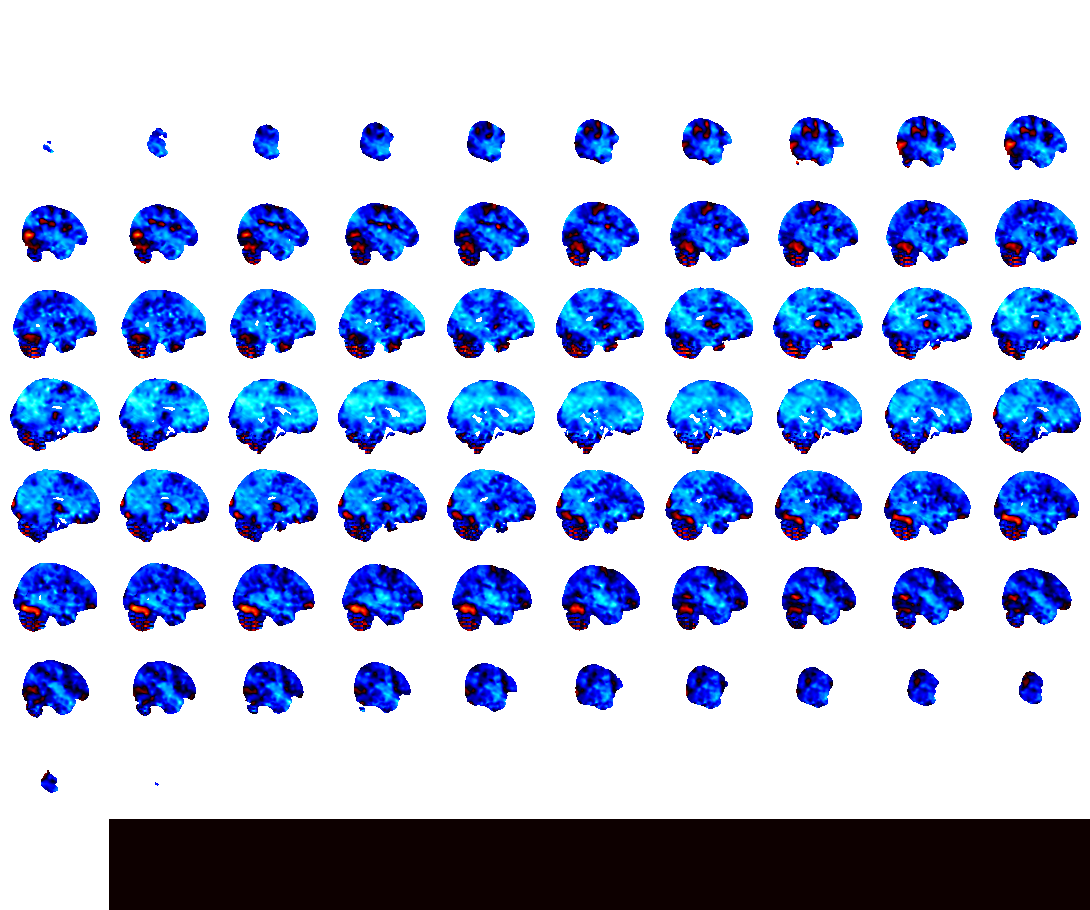

In [12]:
view_img(z_map)

We can threshold our map such that we only show significantly activated voxels, using _p_ < .05 (_z_ > 1.96).


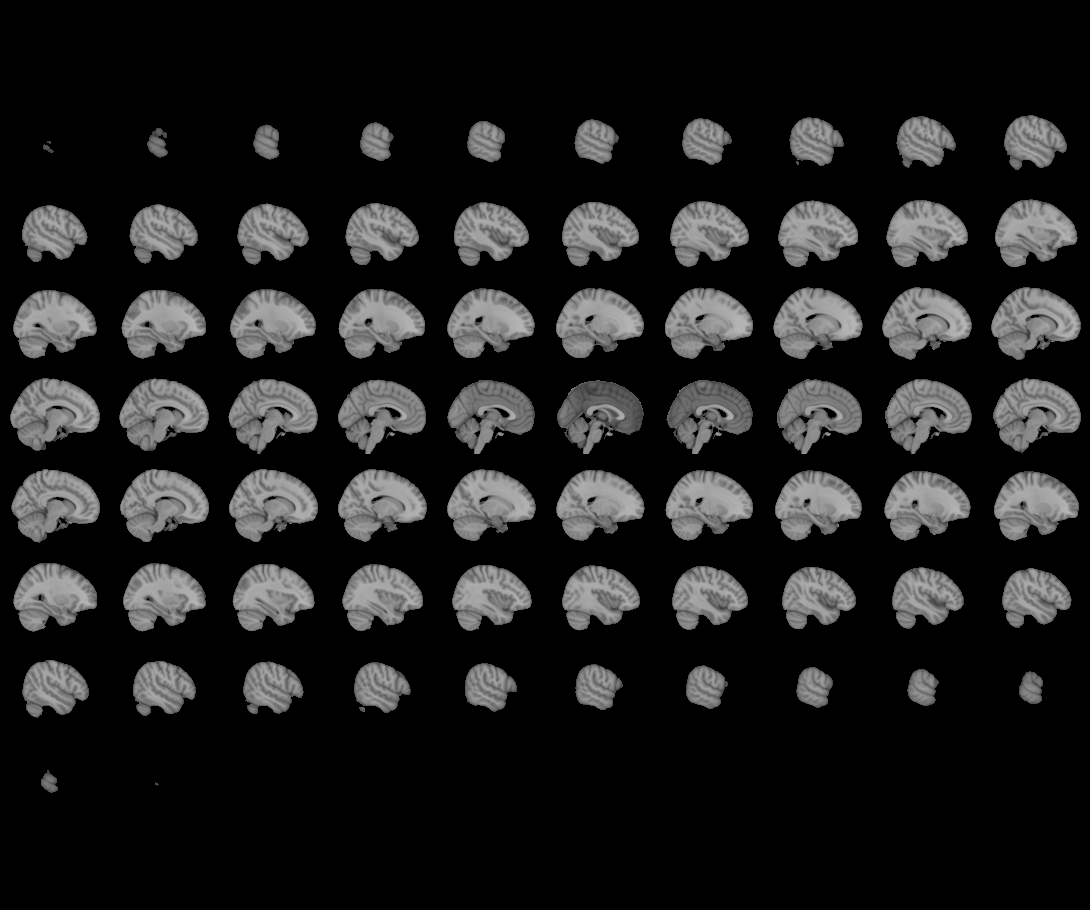
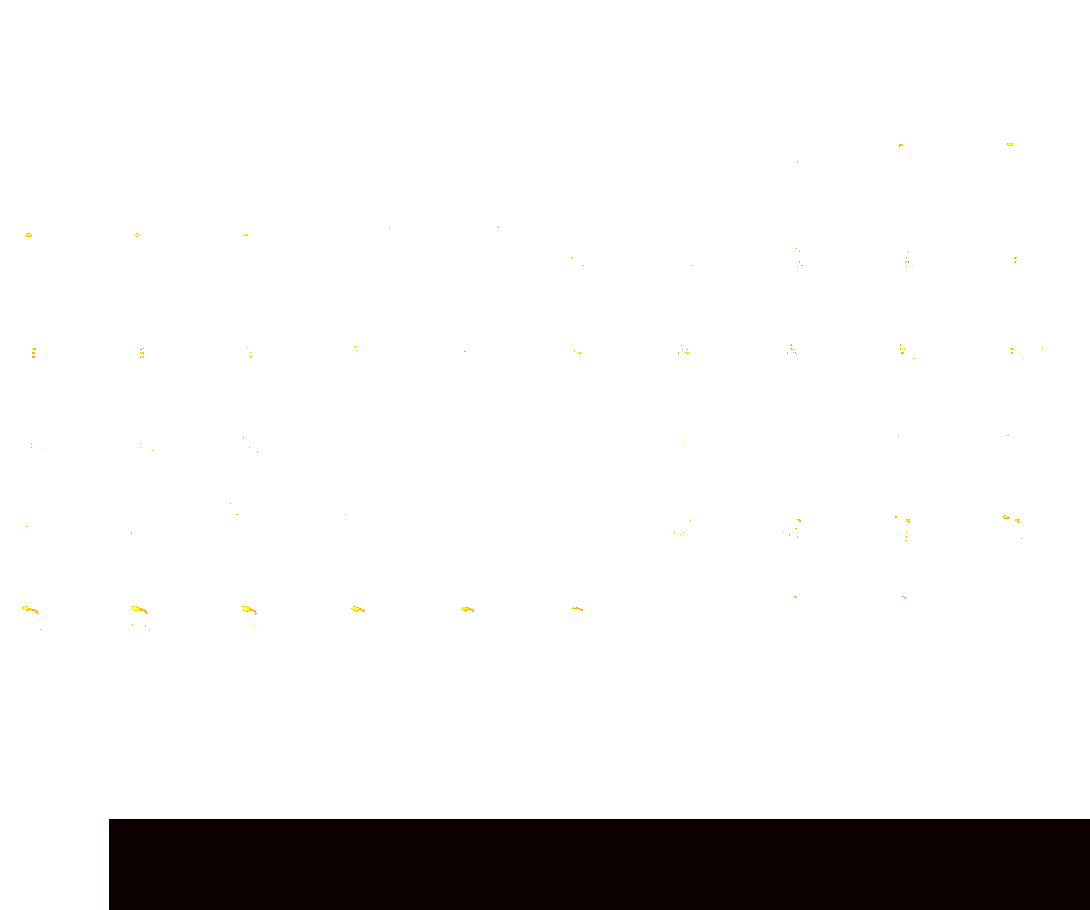

In [16]:
thresh_img, thresh = map_threshold(z_map, threshold=1.96, height_control=None)
view_img(thresh_img)

In addition to showing our results, we need to give information about the significant clusters we obtained. We want to report cluster location, size, and the magnitude of it's activity. We can get all of this cluster information from the `get_clusters_table` function in the `reporting` module.

Because we're interesed in _clusters_ of voxels, rather than random isolated voxels that pass the significance threshold, we can use `cluster_threshold` to set the minimum number of required contiguous voxels.

This function will return a pandas DataFrame with all of the information we need to report in a paper (other than the anatomical location):

In [30]:
results = get_clusters_table(z_map, stat_threshold=1.96, cluster_threshold=10)
results

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,32.0,-76.0,-14.0,3.341794,2520
1,1a,32.0,-52.0,-26.0,2.712441,
2,1b,26.0,-56.0,-22.0,2.609288,
3,1c,36.0,-56.0,-20.0,2.427372,
4,2,-50.0,-68.0,2.0,3.100882,528
5,3,-28.0,-62.0,-58.0,2.841127,136
6,4,-14.0,-68.0,-44.0,2.806655,216
7,5,-18.0,-62.0,-50.0,2.743121,112
8,6,-28.0,-62.0,-50.0,2.494946,152
9,7,-30.0,-62.0,-44.0,2.472527,144


## 2. Multiple Comparisons